Good project vs. great project = difference of about \$30k-\$40k
Don't delete cells
Pipeline
preliminary modeling
Different jupyter notebook for different tasks: import and EDA on weather data, import and EDA on ICO index, etc.
Connect trello board with links

# Development Code

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

plt.style.use("fivethirtyeight")
# sns.set_palette("muted")
%matplotlib inline

### Finding the coffee production schedule

In [21]:
# unformatted_coffee_production_seasons = pd.read_csv("../datasets/capstone/Coffee Producing Countries and Their Harvest Seasons.csv")

# coffee_production_seasons = pd.DataFrame()

# for i, row in enumerate(unformatted_coffee_production_seasons.index):
#     if unformatted_coffee_production_seasons["Producing Country"].isnull().loc[row]:
#         unformatted_coffee_production_seasons.loc[row, "Producing Country"] = unformatted_coffee_production_seasons.ix[i - 1, "Producing Country"]

# coffee_production_seasons = pd.concat(objs = [unformatted_coffee_production_seasons, 
#                   unformatted_coffee_production_seasons["Harvest Season"].str.split("-", expand = True)
#                  ], axis = 1)

# coffee_production_seasons.columns = ["Producing Country", 
#                                      "Coffee Type", 
#                                      "Harvest Season", 
#                                      "Harvest Begins", 
#                                      "Harvest Ends", 
#                                      "Year-round Harvest"]

# for row in coffee_production_seasons[~ coffee_production_seasons["Year-round Harvest"].isnull()].index:
#     coffee_production_seasons.iloc[row, 3] = coffee_production_seasons.iloc[row, 4].replace("Peak ", "")
#     coffee_production_seasons.iloc[row, 4] = coffee_production_seasons.iloc[row, 5]
#     coffee_production_seasons.iloc[row, 5] = True
    
# coffee_production_seasons.loc[:, "Year-round Harvest"] = coffee_production_seasons["Year-round Harvest"].map({None: False, True: True})

# coffee_production_seasons.drop("Harvest Season", axis = 1, inplace = True)

# coffee_production_seasons.to_csv("../datasets/capstone/coffee harvest schedule.csv")

pd.read_csv("../datasets/capstone/coffee harvest schedule.csv", index_col = 0).head(8)


,Producing Country,Coffee Type,Harvest Begins,Harvest Ends,Year-round Harvest
0,Angola,Arabica,April,June,False
1,Angola,Robusta,May,September,False
2,Benin,Robusta,November,February,False
3,Bolivia,Arabica,April,August,False
4,Borneo,Arabica,June,December,False
5,Borneo,Robusta,May,December,False
6,Brazil,Arabica,April,September,False
7,Brazil,Robusta,April,September,False


### Defining season

In [3]:
northern_hemisphere_seasons = {1: 'winter', 2: 'winter', 3: 'winter', 4: 'spring', 5: 'spring', 6: 'spring', 7: 'summer', 8: 'summer', 9: 'summer', 10: 'fall', 11: 'fall', 12: 'fall'}
southern_seasons = {7: 'winter', 8: 'winter', 9: 'winter', 10: 'spring', 11: 'spring', 12: 'spring', 1: 'summer', 2: 'summer', 3: 'summer', 4: 'fall', 5: 'fall', 6: 'fall'}

def get_season (date, seasons_dictionary = None):
    season = seasons_dictionary[date.month]
    return season

### Selecting weather stations by growing conditions

In [4]:
raw_station_ids = pd.read_csv("../datasets/capstone/NOAA-station-ids-isd-history.txt", header = 17)

In [5]:
station_ids = raw_station_ids.copy()
station_ids_column_names = station_ids.columns[0].split()
station_ids = station_ids.iloc[:, 0].str.split(expand = True)

In [6]:
brazilian_station_ids = station_ids[station_ids[3] == "BR"].dropna(axis = 1)
brazilian_station_ids.columns = ["USAF", "WBAN", "City", "Country", "Latitude", "Longitude", "Elevation", "Begin", "End"]
brazilian_station_ids.drop(21926, inplace = True) # Error in formatting
brazilian_station_ids.reset_index(drop = True, inplace = True)
brazilian_station_ids.loc[:, ["Latitude", "Longitude", "Elevation"]] = brazilian_station_ids[["Latitude", "Longitude", "Elevation"]].apply(pd.to_numeric, errors = 'coerce')
brazilian_station_ids.dropna(inplace = True)

In [7]:
# Elevation in meters. Look between 548 m - 1100 m (1800-3600 feet) for latitudes between 16 and 24 degrees, or 1097 m - 1920 m (3600 feet to 6300 feet)
arabica_growing_conditions_criteria = (brazilian_station_ids["Elevation"] >= 548) & (brazilian_station_ids["Elevation"] <= 1100) & (brazilian_station_ids["Latitude"].abs() > 16) & (brazilian_station_ids["Latitude"].abs() <= 24)
arabica_growing_conditions_criteria = arabica_growing_conditions_criteria | ((brazilian_station_ids["Elevation"] >= 1097) & (brazilian_station_ids["Elevation"] <= 1920) & (brazilian_station_ids["Latitude"].abs() <= 10))

# Robusta grows best in elevations 0 m - 914 m (sea level-3000 feet) in latitudes between ±10° 
robusta_growing_conditions_criteria = (brazilian_station_ids["Elevation"] <= 914) & (brazilian_station_ids["Latitude"].abs() <= 10)

# Look for data that exists between 1990 and 2017
time_availability_criteria = (brazilian_station_ids["Begin"].astype(int) < 19900000) & (brazilian_station_ids["End"].astype(int) > 20160000)

# Applying criteria
brazilian_station_ids = brazilian_station_ids[arabica_growing_conditions_criteria & time_availability_criteria]

print(brazilian_station_ids.shape[0])
print("Station ids: ", sorted(brazilian_station_ids.USAF.values))

9
Station ids:  ['834230', '834790', '835260', '835790', '835820', '835920', '836300', '836870', '837660']


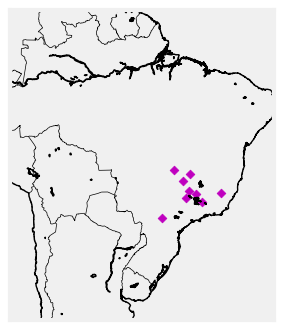

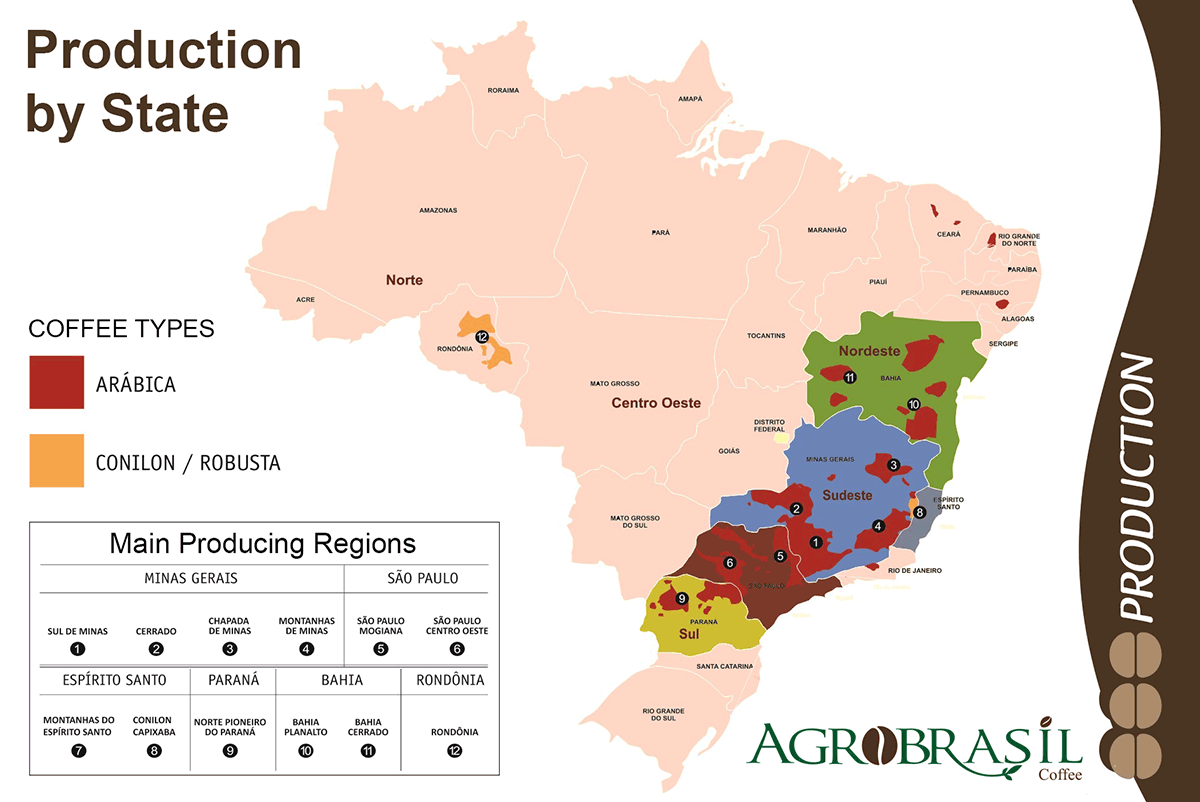

In [8]:
from mpl_toolkits.basemap import Basemap

lons = brazilian_station_ids["Longitude"].tolist()
lats = brazilian_station_ids["Latitude"].tolist()

map = Basemap(llcrnrlon=-77,llcrnrlat=-34,urcrnrlon=-35.,urcrnrlat=6,
             resolution='i', projection='tmerc', lat_0 = -14.5, lon_0 = -47)

x, y = map(lons, lats)
map.scatter(x, y, marker='D',color='m')

map.drawcoastlines()
map.drawcountries()

plt.show()

Image("http://www.agrobrasilcoffee.com/uploads/images/conteudo/Production-by-State-Map.png")

### Downloading weather data from NCDC at NOAA

Text download:
https://www7.ncdc.noaa.gov/CDO/cdo

API:
https://www.ncdc.noaa.gov/cdo-web/webservices/v2

Monthly weather data:
    https://catalog.data.gov/dataset/monthly-summaries-of-the-global-historical-climatology-network-daily-ghcn-d/resource/4f277848-e3e9-4528-8963-a97475e0c226

In [9]:
# Import NOAA data for Brazil
raw_brazil_weather_data = pd.read_csv("../datasets/capstone/Production Arabica Brazil 1989 - 2013 -- CDO537887251283.txt")

In [10]:
brazil_weather_data = raw_brazil_weather_data.copy()

# Removing whitespace from columns names
clean_brazil_weather_data_column_names = []
for column in brazil_weather_data.columns:
    clean_brazil_weather_data_column_names.append(column.strip())
brazil_weather_data.columns = clean_brazil_weather_data_column_names

# Dropping unnecessary columns
brazil_weather_data.drop(labels = ["Unnamed: 22"], axis = 1, inplace = True)
brazil_weather_data.drop(labels = ["GUST", "SNDP"], axis = 1, inplace = True)

# Converting time column and extracting month, year
brazil_weather_data["YEARMODA"] = brazil_weather_data["YEARMODA"].apply(pd.to_datetime, format = "%Y%m%d")
brazil_weather_data["month"] = brazil_weather_data["YEARMODA"].apply(lambda x: x.month)
brazil_weather_data["year"] = brazil_weather_data["YEARMODA"].apply(lambda x: x.year)

# Adding seasons
brazil_weather_data["season"] = brazil_weather_data["YEARMODA"].apply(get_season, seasons_dictionary = southern_seasons)

# Converting temperature data to numbers
brazil_weather_data["MAX"] = brazil_weather_data["MAX"].replace("\*", "", regex = True).apply(pd.to_numeric, errors = 'coerce')
brazil_weather_data["MIN"] = brazil_weather_data["MIN"].replace("\*", "", regex = True).apply(pd.to_numeric, errors = 'coerce')

# Converting precipitation data
brazil_weather_data["prcp_code"] = brazil_weather_data["PRCP"].str[-1]
brazil_weather_data["PRCP"] = brazil_weather_data["PRCP"].str[0:-1]
brazil_weather_data["PRCP"] = brazil_weather_data["PRCP"].apply(pd.to_numeric, errors = 'coerce')

# Setting null values
brazil_weather_data[brazil_weather_data["MAX"] == 999.99] = np.NaN
brazil_weather_data[brazil_weather_data["MIN"] == 9999.9] = np.NaN
brazil_weather_data[brazil_weather_data["PRCP"] == 99.99] = np.NaN
brazil_weather_data[brazil_weather_data["DEWP"] >= 9999] = np.NaN

# Drop null values
print("Dropping null values reduced rows by {}%.".format(100 * round(1 - brazil_weather_data.dropna().shape[0] / brazil_weather_data.shape[0], 3)))
brazil_weather_data.dropna(inplace = True)

Dropping null values reduced rows by 8.4%.


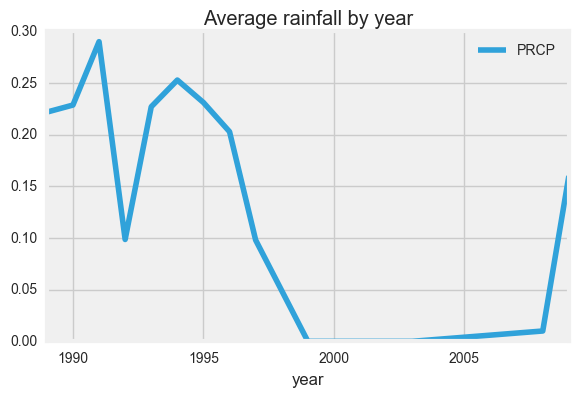

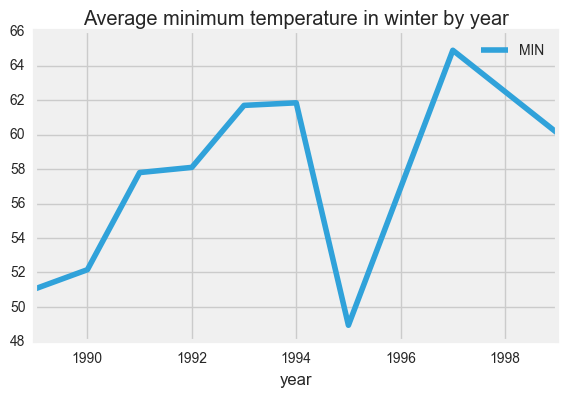

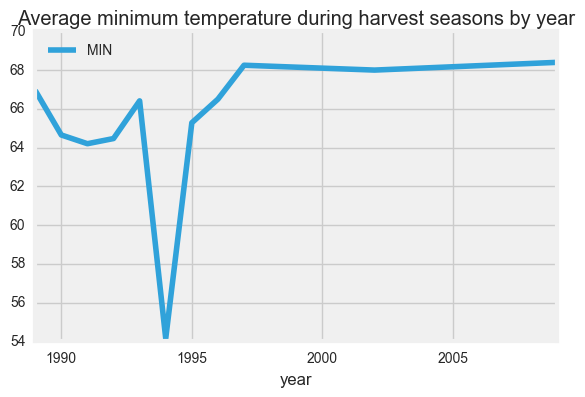

In [55]:
brazil_weather_data[["year", "PRCP"]].groupby(by = "year").mean().plot()
plt.title("Average rainfall by year")
plt.show()

brazil_weather_data[brazil_weather_data["season"] == "winter"][["year", "MIN"]].groupby(by = "year").mean().plot()
plt.title("Average minimum temperature in winter by year")
plt.show()

brazil_weather_data[(brazil_weather_data["season"] == "summer") | (brazil_weather_data["season"] == "spring")][["year", "MIN"]].groupby(by = "year").mean().plot()
plt.title("Average minimum temperature during harvest seasons by year")
plt.show()

Winter colds would affect following year, or the next 6-7 years if the trees needed to be replanted.

"https://www.nasa.gov/feature/goddard/nasas-grace-satellites-evaluate-drought-in-southeast-brazil"

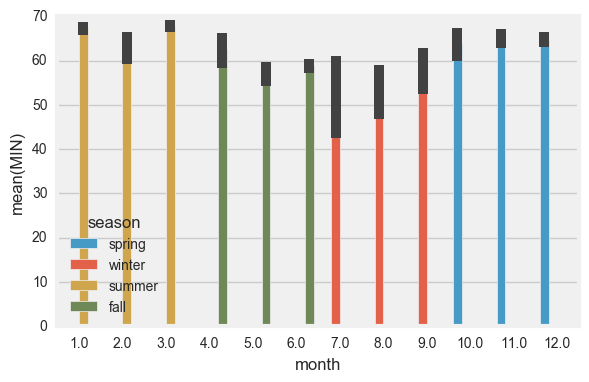

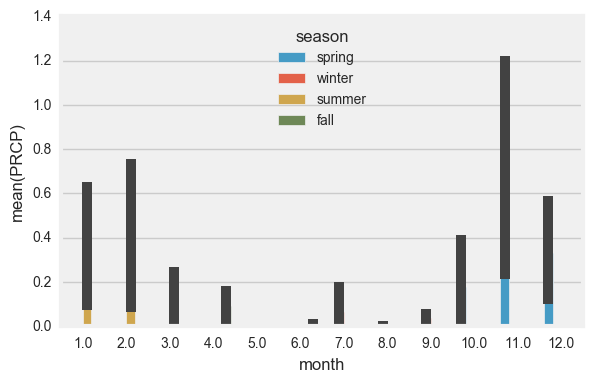

In [12]:
# brazil_weather_data[brazil_weather_data["season"] == "summer"].plot(x = "YEARMODA", y = "MIN", c = 'r')
# brazil_weather_data[brazil_weather_data["season"] == "spring"].plot(x = "YEARMODA", y = "MIN", c = 'b')

# brazil_weather_data.plot(x = "YEARMODA", y = "PRCP")
# plt.scatter(x = NOAA_data["MIN"], y = NOAA_data["DEWP"])


sns.barplot(x = "month", y = "MIN", data = brazil_weather_data, hue = "season")
plt.show()

sns.barplot(x = "month", y = "PRCP", data = brazil_weather_data, hue = "season")
plt.show()


Can I use indicies, IMF import data